Matplotlib is building the font cache; this may take a moment.


Compute mL2 (mL2 ± delta):
m1: 16.42 ± 26.30  => [-9.88, 42.72]
m2: 96.97 ± 10.98  => [85.99, 107.95]
m3: 9.41 ± 1.94  => [7.47, 11.35]


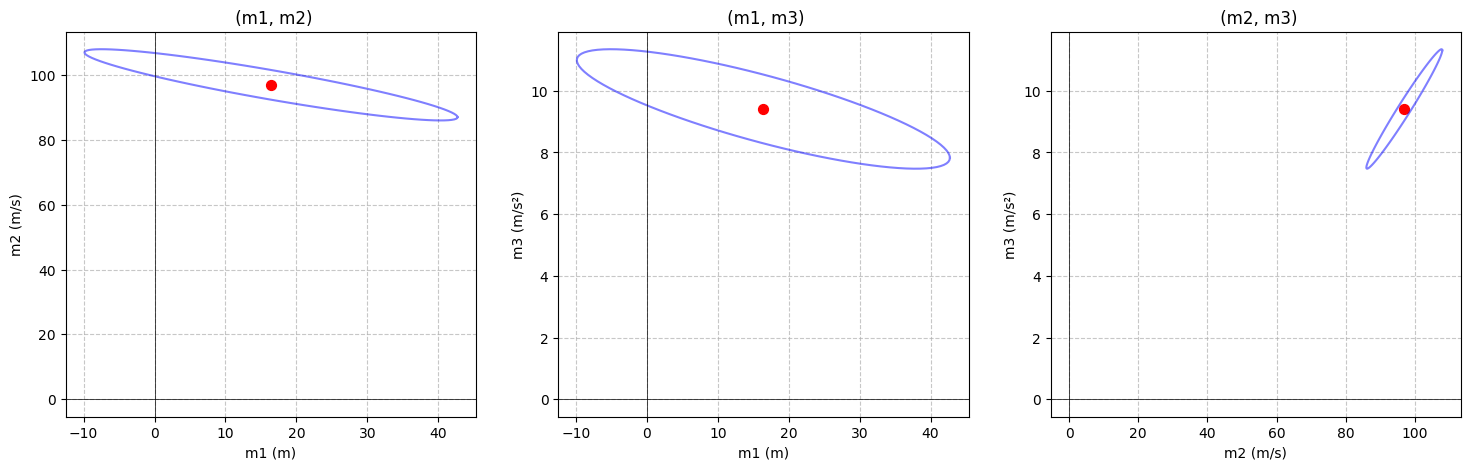

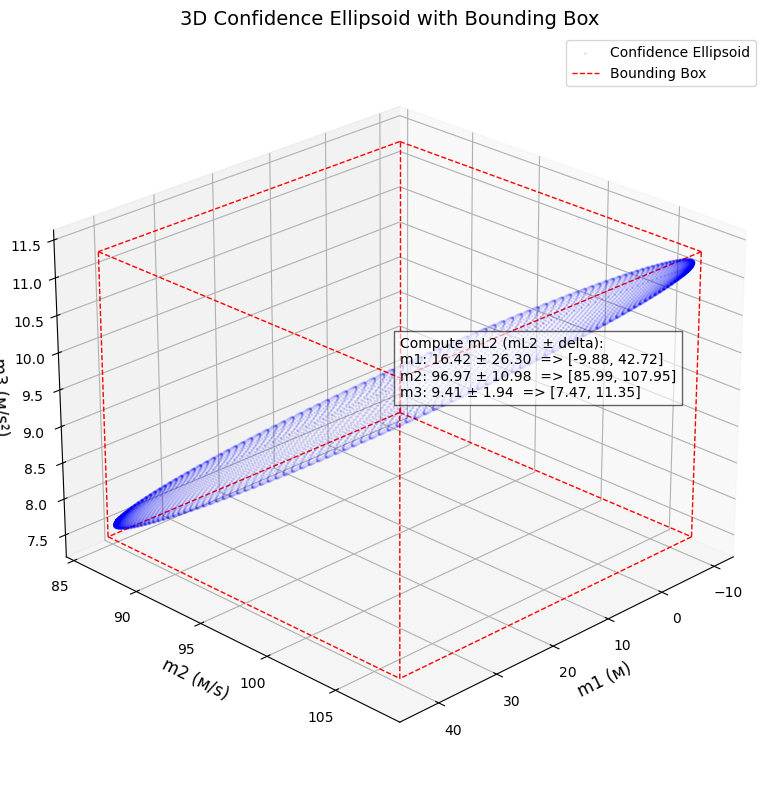

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import chi2
from mpl_toolkits.mplot3d import Axes3D
"Data"
# t = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
# y = np.array([109.4, 187.5, 267.5, 331.9, 386.1, 428.4, 452.2, 498.1, 512.3, 513.0]) 
# y = m1 + m2*t - 0.5*m3*t**2 - equation 
# mL1, mL2, mL3 = 16.42m, 96.97m/s, 9.41 using Least square 
# mL2 = (((G(w)^T)*G(w))^-1)*(G(w)^T)*d(w)
# mtrue = [10m, 100m/s, 9.8m/s^2]
# sigma = σ = 8м - noise
# m=10, n=3
"""G = np.array([
    [1, 1, 0.5],
    [1, 2, 2.0],
    [1, 3, 4.5],
    [1, 4, 8.0],
    [1, 5, 12.5],
    [1, 6, 18.0],
    [1, 7, 24.5],
    [1, 8, 32.0],
    [1, 9, 40.5],
    [1, 10, 50.0]
])"""


# Covariace matrix - dependence between parameters
#Cov = σ^2 * ((G^T)*G)^-1 equation Cov = 
Cov = np.array([
    [88.53, -33.60, -5.33],
    [-33.60, 15.44, 2.67],
    [-5.33, 2.67, 0.48]
])
# Диспресия Var(m1) = 88.53 Var(m2) = 15.44m/s Var(m3) = 0.48m/s^2
# Estimates parameter 95% confidence intervals   
# Calculate the Standard Errors SE = Var(m)^-0.5
# SE1=9.41, SE2=3.93 SE3=0.69 
mL2 = np.array([16.42, 96.97, 9.41])
# Confidence Intervals
# m1=16.4m-+ 18.4m ->[-2.0, 34.8] 
# m2=97.0m/s-+ 7.7m/s ->[89.3, 104.7]
# m3=9.4m/s^2-+ 1.4m/s^2 ->[8.0, 10.8]

"Interpretation:mtrue values fall within the Confidence Intervals, Estimate is consistent despite the noise!"
# Result mtrue and mL2 estimate a little bit diffrent because σ=8м - noise

# χ²value 
chi2_crit = chi2.ppf(0.95, 3)  # chi2.ppf(95%, v) χ² ≈ 7.815, v= m-n = 10-3 = 7
"Interpretation: If χ² ≈ v, the model is consistent with the data!"

"95% CONFIDENCE ELLIPSOID"
# Parametrs ellipsoid

Cinv = np.linalg.inv(Cov) # Inverse matrix covariace
# corresponding eigenvalues and vectors Cinv
eigenvals, eigenvecs = np.linalg.eigh(Cinv)
# Sorting in descending order of eigenvalues
eigenvals = eigenvals[::-1]
eigenvecs = eigenvecs[:, ::-1]
# Lengths of the semi-axes of the ellipsoid
semi_axes = np.sqrt(chi2_crit / eigenvals)

"Generate point ellipsoid"
# parametrs 
theta = np.linspace(0, 2*np.pi, 100)    
circle = np.array([np.cos(theta), np.sin(theta)])

# Create 3 graphs
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

# For every projections
for i, (pair, ax) in enumerate(zip([(0,1), (0,2), (1,2)], axs)):
    # Index parametrs for every projections
    idx1, idx2 = pair
    
    # Extract the covariance submatrix for the selected parameters Выделяем подматрицу ковариации для выбранных параметров
    Cov_sub = Cov[[[idx1, idx1], [idx2, idx2]], [[idx1, idx2], [idx1, idx2]]]
    
    # Create ellips for projections
    L = np.linalg.cholesky(Cov_sub)  # Разложение Холецкого
    ellipse = (L @ (circle * np.sqrt(chi2_crit)) + mL2[[idx1, idx2]].reshape(2,1))
    
    # ellips
    ax.plot(ellipse[0], ellipse[1], color='blue', alpha=0.5)
    ax.scatter(mL2[idx1], mL2[idx2], color='red', s=50)
    
    # LAbes
    labels = ['m1 (m)', 'm2 (m/s)', 'm3 (m/s²)']
    ax.set_xlabel(labels[idx1])
    ax.set_ylabel(labels[idx2])
    
    # Graps titles
    titles = [' (m1, m2)', ' (m1, m3)', ' (m2, m3)']
    ax.set_title(titles[i])
    
    # Grid
    ax.grid(True, linestyle='--', alpha=0.7)
    ax.axhline(0, color='black', linewidth=0.5)
    ax.axvline(0, color='black', linewidth=0.5)
    
""" ------------------------- 3D vizual -------------------------"""
from itertools import product

# paramets for sphere
u = np.linspace(0, 2*np.pi, 100)
v = np.linspace(0, np.pi, 100)
x = np.outer(np.cos(u), np.sin(v))
y = np.outer(np.sin(u), np.sin(v))
z = np.outer(np.ones_like(u), np.cos(v))
sphere_points = np.vstack([x.flatten(), y.flatten(), z.flatten()])

# Transform sphere to ellipsoid
scaled_points = sphere_points * semi_axes[:, np.newaxis]
rotated_points = eigenvecs @ scaled_points
ellipsoid_points = rotated_points + mL2[:, np.newaxis]

""" bounding box """
deltas = np.ptp(ellipsoid_points, axis=1) / 2
intervals = np.vstack([mL2 - deltas, mL2 + deltas]).T

# Output of intervals for comparison with equation 2.50
print("Compute mL2 (mL2 ± delta):")
print("m1: {:.2f} ± {:.2f}  => [{:.2f}, {:.2f}]".format(mL2[0], deltas[0],
      mL2[0]-deltas[0], mL2[0]+deltas[0]))
print("m2: {:.2f} ± {:.2f}  => [{:.2f}, {:.2f}]".format(mL2[1], deltas[1],
      mL2[1]-deltas[1], mL2[1]+deltas[1]))
print("m3: {:.2f} ± {:.2f}  => [{:.2f}, {:.2f}]".format(mL2[2], deltas[2],
      mL2[2]-deltas[2], mL2[2]+deltas[2]))

# Plot 3d
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# ellipsoid
ax.scatter(ellipsoid_points[0], ellipsoid_points[1], ellipsoid_points[2], 
           c='blue', alpha=0.1, s=1, label='Confidence Ellipsoid')

# Углы bounding box
corners = np.array(list(product(
    [intervals[0, 0], intervals[0, 1]],
    [intervals[1, 0], intervals[1, 1]],
    [intervals[2, 0], intervals[2, 1]]
)))

# edge bounding box
for i, edge in enumerate([
    [0,1], [0,2], [0,4],
    [1,3], [1,5],
    [2,3], [2,6],
    [3,7],
    [4,5], [4,6],
    [5,7],
    [6,7]
]):
    if i == 0:
        ax.plot(*zip(*corners[edge]), color='red', linestyle='--', linewidth=1, label='Bounding Box')
    else:
        ax.plot(*zip(*corners[edge]), color='red', linestyle='--', linewidth=1)


# label
bbox_center = np.mean(corners, axis=0)
annotation_text = ("Compute mL2 (mL2 ± delta):\n" +
                   "m1: 16.42 ± {:.2f}  => [{:.2f}, {:.2f}]\n".format(deltas[0], mL2[0]-deltas[0], mL2[0]+deltas[0]) +
                   "m2: 96.97 ± {:.2f}  => [{:.2f}, {:.2f}]\n".format(deltas[1], mL2[1]-deltas[1], mL2[1]+deltas[1]) +
                   "m3: 9.41 ± {:.2f}  => [{:.2f}, {:.2f}]".format(deltas[2], mL2[2]-deltas[2], mL2[2]+deltas[2]))
ax.text(bbox_center[0], bbox_center[1], bbox_center[2], annotation_text, 
        fontsize=10, color='black', bbox=dict(facecolor='white', alpha=0.6))

# label and titels
ax.set_xlabel('m1 (м)', fontsize=12)
ax.set_ylabel('m2 (м/s)', fontsize=12)
ax.set_zlabel('m3 (м/s²)', fontsize=12)
ax.set_title('3D Confidence Ellipsoid with Bounding Box', fontsize=14)

ax.view_init(elev=25, azim=45)
ax.legend()
ax.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
Result 
In this work, the following steps were carried out:
1.Computation of the covariance matrix
2.Calculation of the ellipsoid parameters
3.Generation of the 3D ellipsoid
4.Construction of the bounding box
5.Visualization
Interpretation
- mtrue values fall within the Confidence Intervals, Estimate is consistent despite the noise!
- If χ² ≈ v, where are χ² ≈ 7.815, v= m-n = 10-3 = 7 the model is consistent with the data!
- Accounting for correlations between parameters increases the confidence intervals!
- The rectangular region includes points outside the ellipsoid, which explains the probability being greater than 95%!
- This has been confirmed  [m1,m2,m3] [16.42+-26.25m,96.97+-10.24m/s,9.41+-1.65m/s^2]